In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [66]:
train_df = pd.read_csv("data/train.csv", low_memory=True).iloc[:,1:]  # drop index column

In [ ]:
train_df.head()

# Exploratory Data Analysis

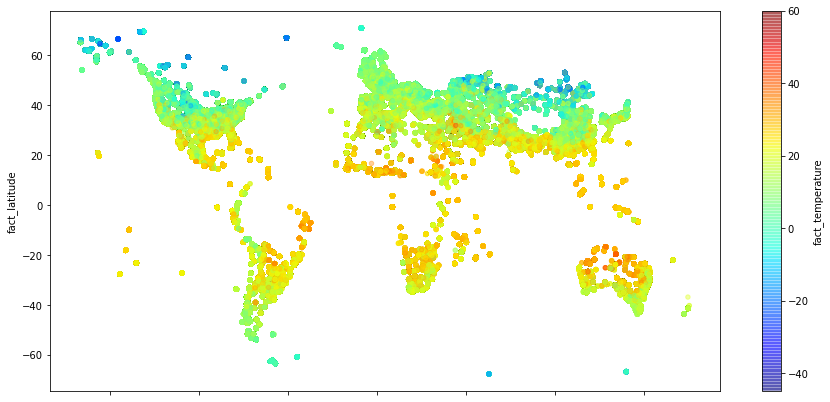

In [44]:
# let's inspect geographical data
# First, look at temperature in different areas
train_df.plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4, c="fact_temperature",
              cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,7))
plt.show()

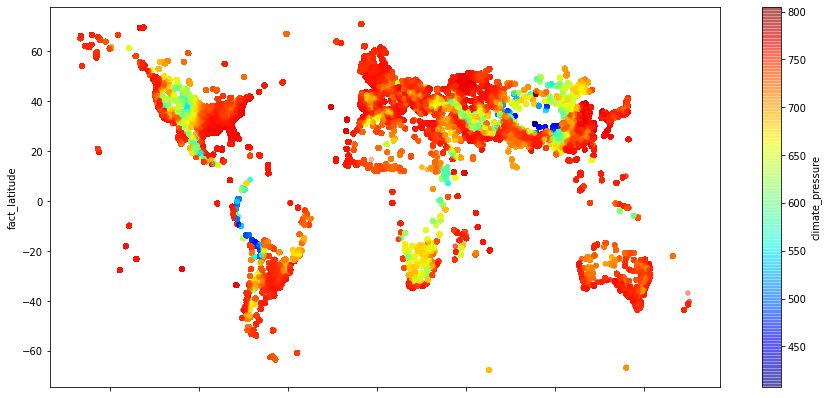

In [45]:
# Now, look at climate pressure in different areas
train_df.plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4, c="climate_pressure",
              cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,7))
plt.show()

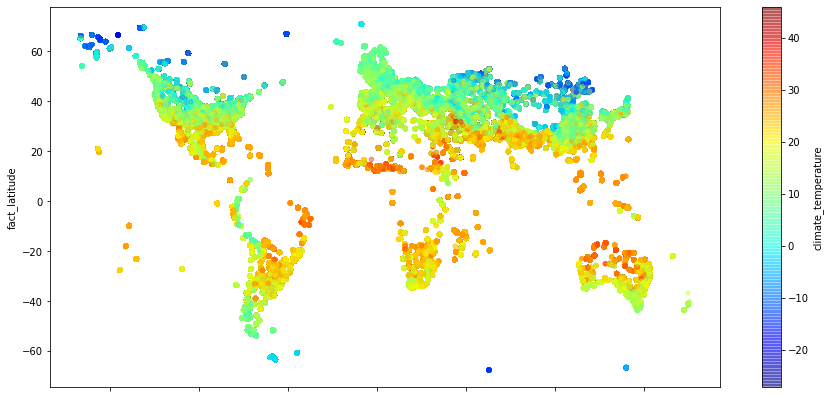

In [46]:
# Look at climate temperature in different areas
train_df.plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4, c="climate_temperature",
              cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,7))
plt.show()

We can see how training data is coming from all around the world, with some exceptions: center and north South America and center of Africa.

## Target Variable

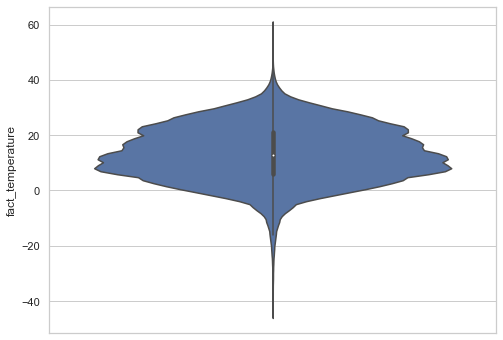

In [48]:
import seaborn as sns

def plot_violin_plot(column):
  sns.set_theme(style="whitegrid")
  ax = sns.violinplot(y=column)

plt.figure(figsize=(8,6))
plot_violin_plot(train_df["fact_temperature"])
plt.show()

In [49]:
percentile_99_99 = train_df["fact_temperature"].quantile(0.9999)
percentile_0_01 = train_df["fact_temperature"].quantile(0.0001)
percentile_99_9 = train_df["fact_temperature"].quantile(0.999)
percentile_0_1 = train_df["fact_temperature"].quantile(0.001)
percentile_99 = train_df["fact_temperature"].quantile(0.99)
percentile_1 = train_df["fact_temperature"].quantile(0.1)


print(f"Percentile 99.99 %: {percentile_99_99}")
print(f"Percentile 0.01 %: {percentile_0_01}")
print(f"Percentile 99.9 %: {percentile_99_9}")
print(f"Percentile 0.1 %: {percentile_0_1}")
print(f"Percentile 99 %: {percentile_99}")
print(f"Percentile 1 %: {percentile_1}")

print(f"Percentile 99.99 % data over: { ( train_df['fact_temperature'] >= percentile_99_99).sum()} ")
print(f"Percentile 0.01 % data under: { ( train_df['fact_temperature'] <= percentile_0_01).sum()} ")
print(f"Percentile 99.9 % data over: { ( train_df['fact_temperature'] >= percentile_99_9).sum()} ")
print(f"Percentile 0.1 % data under: { ( train_df['fact_temperature'] <= percentile_0_1).sum()} ")
print(f"Percentile 99 % data over: { ( train_df['fact_temperature'] >= percentile_99).sum()} ")
print(f"Percentile 1 % data under: { ( train_df['fact_temperature'] <= percentile_1).sum()}")

Percentile 99.99 %: 45.0
Percentile 0.01 %: -35.0
Percentile 99.9 %: 41.0
Percentile 0.1 %: -24.0
Percentile 99 %: 34.0
Percentile 1 %: 1.0
Percentile 99.99 % data over: 212 
Percentile 0.01 % data under: 201 
Percentile 99.9 % data over: 2160 
Percentile 0.1 % data under: 2278 
Percentile 99 % data over: 26203 
Percentile 1 % data under: 227510


# Data cleaning

In [50]:
# check that all features are numerical -> yes, so we don't need encoding
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993574 entries, 0 to 1993573
Columns: 112 entries, fact_time to fact_temperature
dtypes: float64(112)
memory usage: 1.7 GB


In [51]:
print(f"NaN values before removing not available records' features: {train_df.isna().sum().sum()}")

NaN values before removing not available records' features: 1154176


In [52]:
print(f"gfs records not available: {(train_df['gfs_available'] == 0).sum()}")
print(f"cmc records not available: {(train_df['cmc_available'] == 0).sum()}")
print(f"wrf records not available: {(train_df['wrf_available'] == 0).sum()}")

gfs records not available: 0
cmc records not available: 1801
wrf records not available: 107133


In [53]:
# 0 if not NaN, 1 if cmc is missing, 2 if wrf is missing
nan_points_cmc = (train_df['cmc_available'] == 0).replace({True: 1, False: 0})
nan_points_wrf = (train_df['wrf_available'] == 0).replace({True: 2, False: 0})
nan_points_flag = pd.concat([nan_points_cmc, nan_points_wrf]).groupby(level=0).sum()
train_df["flag"] = nan_points_flag
train_df.head()

,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,cmc_0_0_7_2,...,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next,fact_temperature,flag
0,1.538665e+09,42.696693,23.411436,532.0,11.436109,15.718571,694.970318,279.984589,10.375,7.625,...,0.0,0.0,0.0,0.0,0.058990,0.808984,0.0,0.0,19.0,0
1,1.539436e+09,51.447778,4.341944,20.0,26.956421,12.511429,759.973131,288.606445,8.375,8.375,...,0.0,0.0,0.0,0.0,0.348022,16.150018,0.0,0.0,25.0,0
2,1.541235e+09,39.175400,-76.668297,42.0,-45.928553,10.842857,759.321626,284.499634,1.125,0.625,...,0.0,0.0,0.0,0.0,-1.500000,5.950006,0.0,100.0,11.0,2
3,1.544501e+09,36.029598,-119.063004,132.0,-25.871600,15.259286,754.582732,278.388733,2.500,0.375,...,0.0,0.0,0.0,0.0,0.299988,6.450006,0.0,0.0,9.0,0
4,1.538634e+09,34.398300,-96.148102,179.0,-61.020501,20.564286,744.448625,294.560196,3.250,4.625,...,0.0,0.0,0.0,0.0,-0.500000,20.749994,0.0,0.0,23.0,0


<AxesSubplot:xlabel='fact_longitude', ylabel='fact_latitude'>

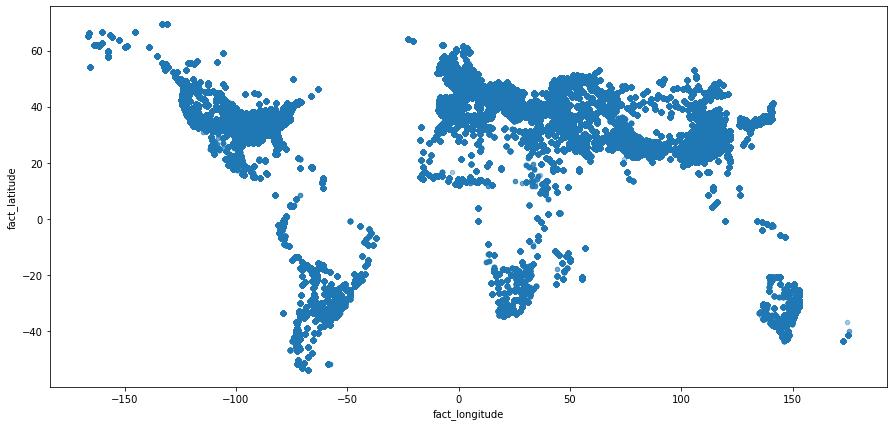

In [43]:
train_df[train_df["flag"] == 0].plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4,
              cmap=plt.get_cmap("jet"), figsize=(15,7))

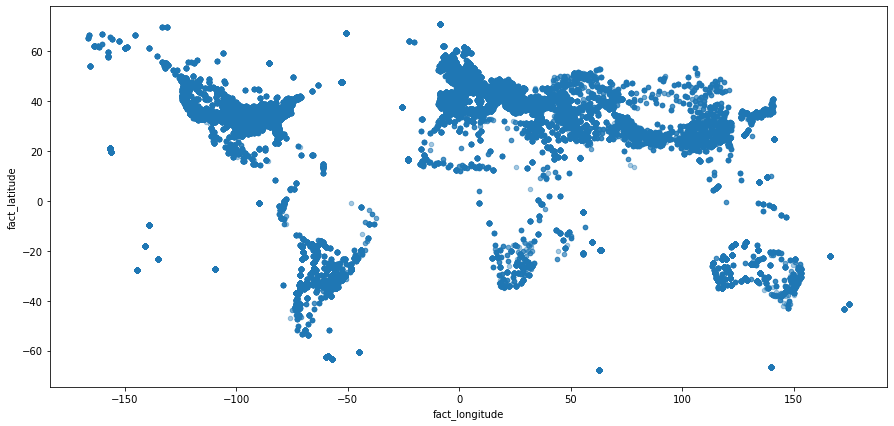

In [41]:
train_df[train_df["flag"] == 2].plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4,
              cmap=plt.get_cmap("jet"), figsize=(15,7))
plt.show()

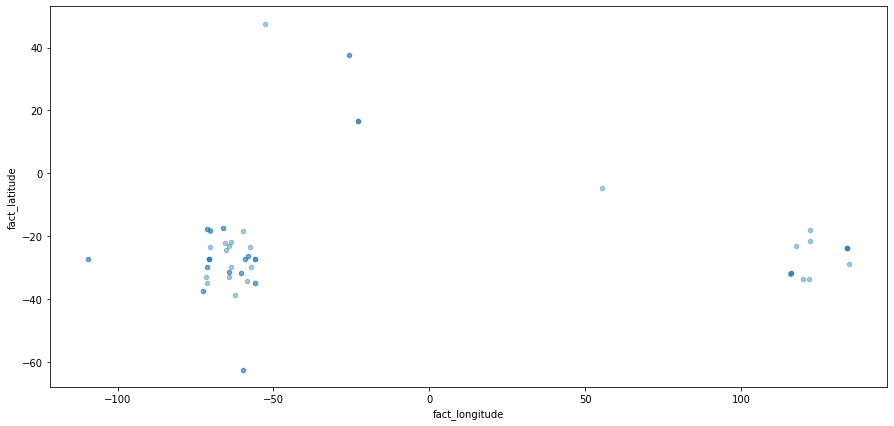

In [42]:
train_df[train_df["flag"] == 3].plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4,
              cmap=plt.get_cmap("jet"), figsize=(15,7))
plt.show()

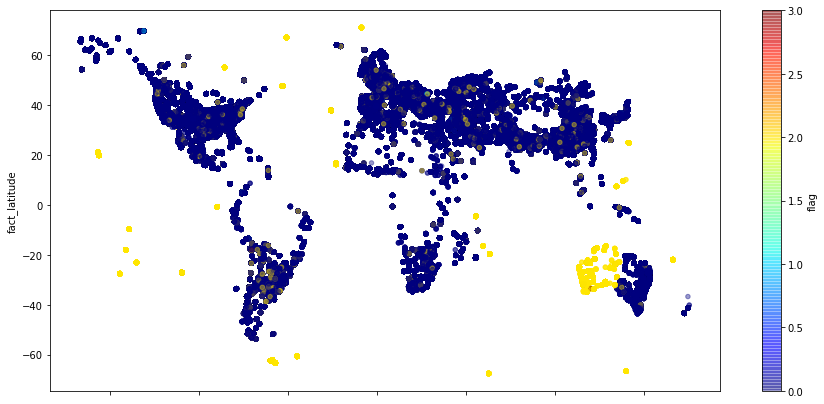

In [37]:
train_df.plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4, c="flag",
              cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,7))
plt.show()

In [54]:
train_df = train_df.drop(columns=["flag"])

In [55]:
from datetime import datetime

def get_hour(date, n_intervals = 6):
    hour = date.hour

    hours_in_interval = 24 // n_intervals

    return hour // hours_in_interval


def get_categorical_month_and_hour(df):

    datetimes = df["fact_time"].apply(datetime.utcfromtimestamp)

    df["month"] = datetimes.apply(lambda date: date.month)
    df["hour"] = datetimes.apply(get_hour) # get hour in intervals

    return pd.get_dummies(data=df, columns=['month', 'hour'])

In [57]:
# remove duplicates
train_df.drop_duplicates(inplace=True, ignore_index=True)
train_df

,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,cmc_0_0_7_2,...,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next,fact_temperature
0,1.538665e+09,42.696693,23.411436,532.0,11.436109,15.718571,694.970318,279.984589,10.375,7.625,...,0.0,0.0,0.0,0.0,0.0,0.058990,0.808984,0.0,0.0,19.0
1,1.539436e+09,51.447778,4.341944,20.0,26.956421,12.511429,759.973131,288.606445,8.375,8.375,...,0.0,0.0,0.0,0.0,0.0,0.348022,16.150018,0.0,0.0,25.0
2,1.544501e+09,36.029598,-119.063004,132.0,-25.871600,15.259286,754.582732,278.388733,2.500,0.375,...,0.0,0.0,0.0,0.0,0.0,0.299988,6.450006,0.0,0.0,9.0
3,1.538634e+09,34.398300,-96.148102,179.0,-61.020501,20.564286,744.448625,294.560196,3.250,4.625,...,0.0,0.0,0.0,0.0,0.0,-0.500000,20.749994,0.0,0.0,23.0
4,1.546056e+09,33.988800,-98.491898,302.0,-42.316609,6.060714,737.828535,267.796906,5.125,3.250,...,0.0,0.0,0.0,0.0,0.0,-1.000000,-6.349982,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879107,1.544270e+09,32.446602,-93.825600,75.0,-27.432883,8.558571,761.212366,280.045334,0.500,0.375,...,0.0,0.0,0.0,0.0,0.0,-1.817993,8.832025,0.0,100.0,5.0
1879108,1.541552e+09,36.191898,-94.489998,361.0,-6.690413,13.887143,732.386076,281.155746,5.500,3.875,...,0.0,0.0,0.0,0.0,0.0,-1.136932,6.113062,16.0,99.0,12.0
1879109,1.545372e+09,38.808899,27.833900,76.0,4.815581,4.407143,750.746603,267.692017,6.625,0.625,...,0.0,0.0,0.0,0.0,0.0,1.314484,0.850000,0.0,0.0,-2.0
1879110,1.544355e+09,18.310000,-15.969722,-7.0,38.690343,19.170714,760.737441,278.651733,19.500,13.250,...,0.0,0.0,0.0,0.0,0.0,1.000000,10.850000,0.0,0.0,28.0


# Outliers removal

In [58]:
# IQR METHOD

percentile25 = train_df['fact_temperature'].quantile(0.25)
percentile75 = train_df['fact_temperature'].quantile(0.75)
iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print(f"Temperature upper limit: {upper_limit}")
print(f"Temperature lower limit: {lower_limit}")

print(f"Number of data that exceeds temperature upper limit: {train_df[train_df['fact_temperature'] > upper_limit].shape[0]}")
print(f"Number of data that exceeds temperature lower limit: {train_df[train_df['fact_temperature'] < lower_limit].shape[0]}")

print(f"Len of train_df: {train_df.shape[0]} ")

train_df =  train_df.drop( train_df[train_df['fact_temperature'] > upper_limit].index) # drop record over the upper limit
train_df =  train_df.drop( train_df[train_df['fact_temperature'] < lower_limit].index) # drop record under the upper limit

print(f"Len of train_df: {train_df.shape[0]}")


Temperature upper limit: 43.5
Temperature lower limit: -16.5
Number of data that exceeds temperature upper limit: 412
Number of data that exceeds temperature lower limit: 7230
Len of train_df: 1879112 
Len of train_df: 1871470


# Features Engineering

In [ ]:
from datetime import datetime

def get_hour(date, n_intervals = 6):
    hour = date.hour
    hours_in_interval = 24 // n_intervals
    return hour // hours_in_interval


def get_month_and_hour(df, test=False):
    datetimes = df["fact_time"].apply(datetime.utcfromtimestamp)
    if not test:
        # save y and add it at the end
        y = df["fact_temperature"]
        df.drop(columns=["fact_time", "fact_temperature"], inplace=True)
        df["month"] = datetimes.apply(lambda date: date.month)
        df["hour"] = datetimes.apply(get_hour) # get hour in intervals
        df["fact_temperature"] = y
    else:
        df.drop(columns=["fact_time"], inplace=True)
        df["month"] = datetimes.apply(lambda date: date.month)
        df["hour"] = datetimes.apply(get_hour) # get hour in intervals
    return df

In [59]:
from datetime import datetime

def get_hour(date, n_intervals = 6):
    hour = date.hour

    hours_in_interval = 24 // n_intervals

    return hour // hours_in_interval


def get_categorical_month_and_hour(df):

    datetimes = df["fact_time"].apply(datetime.utcfromtimestamp)

    df["month"] = datetimes.apply(lambda date: date.month)
    df["hour"] = datetimes.apply(get_hour) # get hour in intervals

    return pd.get_dummies(data=df, columns=['month', 'hour'])

In [60]:
train_df = get_categorical_month_and_hour(train_df)

train_df = train_df.drop(columns=["fact_time"])
train_df.head()

,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,cmc_0_0_7_2,...,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5
0,1.538665e+09,42.696693,23.411436,532.0,11.436109,15.718571,694.970318,279.984589,10.375,7.625,...,0,1,0,0,0,0,0,1,0,0
1,1.539436e+09,51.447778,4.341944,20.0,26.956421,12.511429,759.973131,288.606445,8.375,8.375,...,0,1,0,0,0,0,0,1,0,0
2,1.544501e+09,36.029598,-119.063004,132.0,-25.871600,15.259286,754.582732,278.388733,2.500,0.375,...,0,0,0,1,1,0,0,0,0,0
3,1.538634e+09,34.398300,-96.148102,179.0,-61.020501,20.564286,744.448625,294.560196,3.250,4.625,...,0,1,0,0,0,1,0,0,0,0
4,1.546056e+09,33.988800,-98.491898,302.0,-42.316609,6.060714,737.828535,267.796906,5.125,3.250,...,0,0,0,1,1,0,0,0,0,0


# Feature selection

In [61]:
def get_correlated_features(df, threshold, method='pearson'):
    corr_matrix = df.corr(method=method).abs()
    high_corr_var=np.where(corr_matrix>threshold)
    high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
    # features and how many times they appear in tuples of correlated features
    features_count = pd.Series(sum(np.array(high_corr_var).tolist(), [])).value_counts()
    to_del = set()
    for pair in high_corr_var:
        if features_count[pair[0]] > features_count[pair[1]]:
            to_del.add(pair[0])
        else:
            to_del.add(pair[1])
    return list(to_del)

In [62]:
# drop correlated gfs, cmc and wrf features
df_cmc_gfs_wrf = train_df[train_df.columns.values[train_df.columns.str.contains("gfs") | 
                                                  train_df.columns.str.contains("cmc") |
                                                  train_df.columns.str.contains("wrf")]]

# pearson: linear relation between two variables
features_to_remove_pearson = get_correlated_features(df_cmc_gfs_wrf, threshold=0.8, method='pearson')

# spearman: monotonic relation between a pair of variables
# features_to_remove_spearman = get_correlated_features(df_cmc_gfs_wrf, threshold=0.8, method='spearman')


# See differences between the two methods
# features_to_remove_pearson = set(features_to_remove_pearson)
# features_to_remove_spearman = set(features_to_remove_spearman)

features_to_remove = features_to_remove_pearson
features_to_remove

['gfs_total_clouds_cover_low_next',
 'gfs_pressure',
 'wrf_rh2',
 'gfs_2m_dewpoint_next',
 'cmc_0_1_67_0_next',
 'cmc_0_2_3_700',
 'gfs_temperature_92500',
 'gfs_temperature_95000',
 'gfs_temperature_75000',
 'cmc_0_1_68_0_next',
 'gfs_temperature_65000',
 'cmc_0_2_2_1000',
 'gfs_temperature_80000',
 'gfs_total_clouds_cover_middle',
 'gfs_temperature_35000',
 'cmc_0_2_2_10',
 'cmc_0_2_2_925',
 'cmc_0_0_7_2',
 'gfs_temperature_85000',
 'gfs_soil_temperature_available',
 'cmc_0_1_65_0_next',
 'gfs_temperature_55000',
 'gfs_temperature_90000',
 'cmc_0_1_0_0',
 'wrf_psfc',
 'gfs_temperature_70000',
 'gfs_horizon_h',
 'cmc_0_2_3_1000',
 'cmc_0_1_65_0_grad',
 'cmc_0_3_0_0_next',
 'cmc_0_1_66_0_next',
 'cmc_0_2_2_700',
 'gfs_temperature_45000',
 'cmc_0_2_3_925',
 'gfs_timedelta_s',
 'gfs_temperature_10000',
 'gfs_temperature_7000',
 'gfs_temperature_97500',
 'cmc_0_3_5_1000',
 'gfs_2m_dewpoint',
 'cmc_0_3_5_500',
 'cmc_0_3_5_850',
 'cmc_0_3_5_925',
 'gfs_precipitable_water',
 'gfs_temperature

In [63]:
# check correlation between target variable and other features
corr_target = train_df.corrwith(train_df["fact_temperature"]).sort_values(ascending=False)
corr_target

fact_temperature         1.000000
wrf_t2_interpolated      0.962263
wrf_t2_next              0.956921
gfs_temperature_97500    0.870269
gfs_temperature_95000    0.858910
                           ...   
gfs_temperature_7000    -0.392939
fact_latitude           -0.401962
fact_time               -0.456820
gfs_temperature_15000   -0.497359
gfs_temperature_10000   -0.584612
Length: 121, dtype: float64

In [64]:
final_train_df = train_df.drop(columns=features_to_remove)
final_train_df

fact_latitude  fact_longitude  topography_bathymetry  sun_elevation  \
0            42.696693       23.411436                  532.0      11.436109   
1            51.447778        4.341944                   20.0      26.956421   
2            36.029598     -119.063004                  132.0     -25.871600   
3            34.398300      -96.148102                  179.0     -61.020501   
4            33.988800      -98.491898                  302.0     -42.316609   
...                ...             ...                    ...            ...   
1879107      32.446602      -93.825600                   75.0     -27.432883   
1879108      36.191898      -94.489998                  361.0      -6.690413   
1879109      38.808899       27.833900                   76.0       4.815581   
1879110      18.310000      -15.969722                   -7.0      38.690343   
1879111      33.783333       55.083333                  812.0       3.688021   

         climate_temperature  climate_pressure  cmc_0_0_6_2  cmc_0_0_7_1000  \
0                  15.718571        694.970318   279.984589          10.375   
1                  12.511429        759.973131   288.606445           8.375   
2                  15.259286        754.582732   278.388733           2.500   
3                  20.564286        744.448625   294.560196           3.250   
4                   6.060714        737.828535   267.796906           5.125   
...                      ...               ...          ...             ...   
1879107             8.558571        761.212366   280.045334           0.500   
1879108            13.887143        732.386076   281.155746           5.500   
1879109             4.407143        750.746603   267.692017           6.625   
1879110            19.170714        760.737441   278.651733          19.500   
1879111            21.220714        682.245830   269.141144          18.625   

         cmc_0_0_7_500  cmc_0_0_7_700  ...  wrf_graupel  wrf_t2_grad  \
0             3.814694          0.875  ...          0.0    -2.572845   
1            15.508391         10.000  ...          0.0    -0.216797   
2             7.367288         16.750  ...          0.0    -0.817749   
3            19.181682          7.875  ...          0.0    -0.174805   
4            22.688773          9.500  ...          0.0    -0.623779   
...                ...            ...  ...          ...          ...   
1879107       1.966518          1.750  ...          0.0    -0.147461   
1879108      16.058111         11.250  ...          0.0     0.578003   
1879109      18.831706         24.750  ...          0.0     2.540314   
1879110      29.925248         30.000  ...          0.0     2.347687   
1879111       3.377520          3.125  ...          0.0     3.199921   

         cmc_0_1_66_0_grad  cmc_0_1_67_0_grad  cmc_0_1_68_0_grad  \
0                      0.0                0.0                0.0   
1                      0.0                0.0                0.0   
2                      0.0                0.0                0.0   
3                      0.0                0.0                0.0   
4                      0.0                0.0                0.0   
...                    ...                ...                ...   
1879107                0.0                0.0                0.0   
1879108                0.0                0.0                0.0   
1879109                0.0                0.0                0.0   
1879110                0.0                0.0                0.0   
1879111                0.0                0.0                0.0   

         gfs_2m_dewpoint_grad  gfs_total_clouds_cover_low_grad  month  hour  \
0                    0.058990                              0.0     10     3   
1                    0.348022                              0.0     10     3   
2                    0.299988                              0.0     12     0   
3                   -0.500000                              0.0     10     1   
4                   -1

# Scaling of features

In [36]:
from sklearn.preprocessing import StandardScaler

# Get X_train and y_train and normalize
X_train = final_train_df.drop(columns=['fact_temperature'])
y_train = final_train_df['fact_temperature']

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)

scy = StandardScaler()
scy.fit(y_train.to_numpy().reshape(-1, 1))
y_train = scy.transform(y_train.to_numpy().reshape(-1, 1))

# PCA feature selection

(1993574, 44)


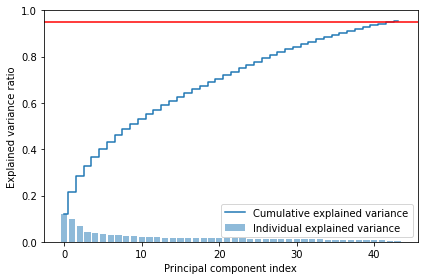

In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X_sf = X_train.copy()


percentage_of_variance = 0.95
pca = PCA(percentage_of_variance)
X_train_pca = pca.fit_transform(X_sf)

In [ ]:
# plot is wrong, the rest should be good
 
exp_var_pca = pca.explained_variance_ratio_

print(X_train_pca.shape)

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.axhline(y=percentage_of_variance, color='r', linestyle='-')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig("charts/pcaRatio.png" , bbox_inches='tight')
plt.show()

In [17]:
print(X_sf.shape)
print(X_train_pca.shape)


(1993574, 66)
(1993574, 44)


# Forward selection

In [23]:
# Feature selection iterative model
import statsmodels.api as sm
from statsmodels.formula.api import ols

# print(X_train)
# print(y_train)

remaining_features = list(X_train.columns)

data = X_train.copy()
data["y"] = y_train[:]

print(remaining_features)

alpha = 0.025

# provo tutte le colonne e se il p value è minore di 0.05 aggiungo a una lista, poi prendo la colonna con il p-value minore
# e la aggiungo al mio modello. Poi riparto con il mio modello aggiornato

selected_features_forward = []
while remaining_features: 
  PF = []  #list of (P value, feature)
  print(f"SELECTED FEATURES: {selected_features_forward}")
  for f in remaining_features:
    temp = selected_features_forward + [f]  #temporary list of features+

    log_reg = sm.Logit(y_train, X_train[temp]).fit()

    p_values = log_reg.pvalues
    min_p_value = np.min(log_reg.pvalues)

    if min_p_value < alpha:
       PF.append((min_p_value,f))
  if PF:  #if not empty
     PF.sort(reverse=True)
     (best_pval, best_f) = PF.pop()
     remaining_features.remove(best_f)
     print('selected feature {} with p-value = {:.2E}'.
            format(best_f, best_pval))
     selected_features_forward.append(best_f)
  else:
     break

print("---------------------------------------------------")
print(selected_features_forward)
print(data)

['index', 'fact_time', 'fact_latitude', 'fact_longitude', 'topography_bathymetry', 'sun_elevation', 'climate_temperature', 'climate_pressure', 'cmc_0_0_6_2', 'cmc_0_0_7_1000', 'cmc_0_0_7_500', 'cmc_0_0_7_700', 'cmc_0_0_7_850', 'cmc_0_0_7_925', 'cmc_0_1_11_0', 'cmc_0_1_65_0', 'cmc_0_1_66_0', 'cmc_0_1_67_0', 'cmc_0_1_68_0', 'cmc_0_1_7_0', 'cmc_0_2_2_500', 'cmc_0_2_2_850', 'cmc_0_2_3_500', 'cmc_0_2_3_850', 'cmc_0_3_0_0', 'cmc_0_3_1_0', 'cmc_0_3_5_850', 'cmc_0_6_1_0', 'cmc_available', 'cmc_horizon_h', 'cmc_precipitations', 'cmc_timedelta_s', 'gfs_a_vorticity', 'gfs_available', 'gfs_cloudness', 'gfs_clouds_sea', 'gfs_humidity', 'gfs_precipitations', 'gfs_r_velocity', 'gfs_soil_temperature', 'gfs_temperature_5000', 'gfs_temperature_15000', 'gfs_temperature_20000', 'gfs_temperature_25000', 'gfs_temperature_97500', 'gfs_total_clouds_cover_high', 'gfs_total_clouds_cover_low', 'gfs_u_wind', 'gfs_v_wind', 'gfs_wind_speed', 'wrf_available', 'wrf_t2_next', 'wrf_psfc', 'wrf_rh2', 'wrf_wind_u', 'wrf_

ValueError: endog must be in the unit interval.

# Train

In [55]:
# grid search cv

param_grid = {
            "alpha": [0.001]
            }
gs = GridSearchCV(estimator=Lasso(), param_grid=param_grid, 
                  scoring="neg_root_mean_squared_error", n_jobs=-1,cv=5, verbose=True)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1, param_grid={'alpha': [0.001]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [ ]:
y_pred = gs.predict(X_test).reshape(-1, 1)

In [ ]:
y_pred = scy.inverse_transform(y_pred)

In [ ]:
print(f"Best set of parameters: {gs.best_params_}")
print(f"Best score: {gs.best_score_}")

In [ ]:
# grid search cv

param_grid = {
            "alpha": [0.001, 0.01, 1]
            }
gs = GridSearchCV(estimator=Lasso(), param_grid=param_grid, 
                  scoring="neg_root_mean_squared_error", n_jobs=-1,cv=5, verbose=True)
gs.fit(X,y)

In [ ]:
# # grid search cv

# param_grid = {
#             "n_estimators": [500],
#             "max_depth": [None],
#             "max_features": ["sqrt"],
#             "criterion": ["mse","gini","entropy"],
#             "random_state": [42]
#             }
# gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, scoring="neg_root_mean_squared_error",
#                   verbose=True, n_jobs=-1,cv=5)
# gs.fit(X,y)

In [ ]:
print(f"Best set of parameters: {gs.best_params_}")
print(f"Best score: {gs.best_score_}")

In [ ]:
# # Now train with full train dataset and best parameters
# model = RandomForestRegressor(n_estimators=500, max_depth=None, max_features="sqrt", criterion="mse", random_state=42)
# model.fit(X_train, y_train)

In [ ]:
# Now train with full train dataset and best parameters
model = Lasso(alpha=0.001)
model.fit(X_train, y_train)

In [ ]:
# Train using a neural network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout


def model():
    model = Sequential()
    model.add(Dense(96, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

model = model()

model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=1024,
        validation_split=0.2,
        verbose=True
)

# Test

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


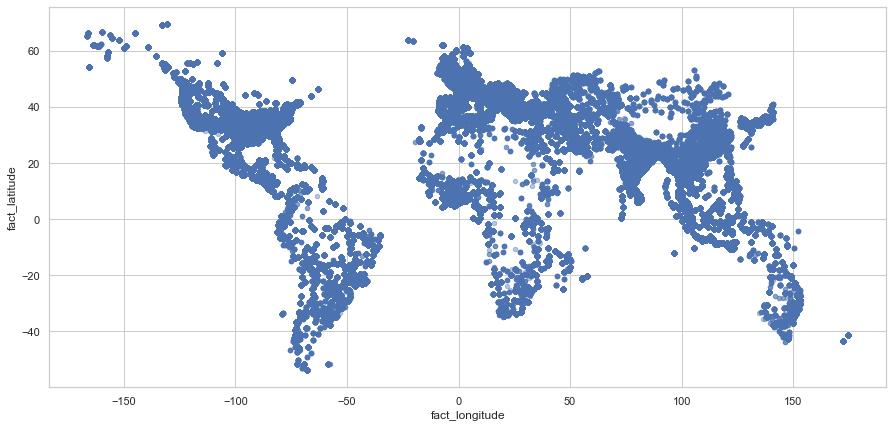

NameError: name 'get_month_and_hour' is not defined

In [67]:
test_df = pd.read_csv("data/test_feat.csv", low_memory=True)
test_df.plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4,
              cmap=plt.get_cmap("jet"), figsize=(15,7))
plt.show()
indices = test_df.pop("index")

# add info about month and hour
test_df = get_categorical_month_and_hour(test_df)
# drop features
final_test_df = test_df.drop(columns=features_to_remove)
final_test_df = final_test_df.drop(columns=["gfs_available", "cmc_available", "wrf_available"])
final_test_df = final_test_df.drop(columns=["fact_time"])

In [ ]:
# APPLY PCA TO TEST
# X_test = final_test_df.to_numpy()
X_test = pca.transform(final_test_df)

In [ ]:
# Get X_test and normalize
X_test = final_test_df.to_numpy()
X_test = sc.transform(X_test)

In [ ]:
y_pred = model.predict(final_test_df)
y_pred = scy.inverse_transform(y_pred)

In [ ]:
print(f"Min value: {y_pred.min()}")
print(f"Max value: {y_pred.max()}")

In [ ]:
submission_df = pd.DataFrame(data={'index': indices.values,
                                   'fact_temperature': y_pred.squeeze()})

# Save the predictions into a csv file
# Notice that this file should be saved under the directory `/kaggle/working` 
# so that you can download it later
submission_df.to_csv("submission.csv", index=False)

# Old stuff

In [ ]:
plt.figure(figsize = (13,8))
nan_corr_df = train_df[nan_cols].corr() 
sns.heatmap(nan_corr_df)
plt.tight_layout()
plt.show()

In [ ]:
nan_corr_mat = nan_corr_df.corr().abs()
# select upper triangle of corr matrix
upper = nan_corr_mat.where(np.triu(np.ones(nan_corr_mat.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(to_drop))
to_drop

In [ ]:
upper['cmc_0_0_7_925']

In [ ]:
train_df.columns.values

In [ ]:
cmc02 = ['cmc_0_2_2_10',
           'cmc_0_2_2_1000', 'cmc_0_2_2_500', 'cmc_0_2_2_700',
           'cmc_0_2_2_850', 'cmc_0_2_2_925', 'cmc_0_2_3_10', 'cmc_0_2_3_1000',
           'cmc_0_2_3_500', 'cmc_0_2_3_700', 'cmc_0_2_3_850', 'cmc_0_2_3_925']
corr_cmc02 = train_df[cmc02].corr() > 0.85
# select upper triangle of corr matrix
upper = corr_cmc02.where(np.triu(np.ones(corr_cmc02.shape), k=1).astype(np.bool))
upper
# to drop: cmc_0_2_2_1000, cmc_0_2_2_925, cmc_0_2_3_1000, cmc_0_2_3_925

In [ ]:
cmc02 = ['cmc_0_2_2_10',
           'cmc_0_2_2_1000', 'cmc_0_2_2_500', 'cmc_0_2_2_700',
           'cmc_0_2_2_850', 'cmc_0_2_2_925', 'cmc_0_2_3_10', 'cmc_0_2_3_1000',
           'cmc_0_2_3_500', 'cmc_0_2_3_700', 'cmc_0_2_3_850', 'cmc_0_2_3_925']
corr_cmc02 = train_df[cmc02].corr() > 0.85
# select upper triangle of corr matrix
upper = corr_cmc02.where(np.triu(np.ones(corr_cmc02.shape), k=1).astype(np.bool))
upper

In [ ]:
final_train_df = train_df.copy()
to_keep = ['fact_latitude','fact_longitude','topography_bathymery','sun_elevation', 'climate_temperature', 'climate_pressure',
         'cmc_0_0_6_2', 'cmc_0_0_7_2', 'cmc_0_0_7_500', 'cmc_0_1_0_0']

In [ ]:
train_df_samples['fact_temperature'].to_numpy()

In [ ]:
train_df_samples = train_df.sample(int(0.4 * len(train_df)))

In [ ]:
y = train_df_samples['fact_temperature'].to_numpy()
X = train_df_samples.fillna(0).iloc[:,:-1].to_numpy()

In [ ]:
# grid search cv

param_grid = {
            "alpha": [1]
            }
gs = GridSearchCV(estimator=Lasso(), param_grid=param_grid, scoring="neg_mean_squared_error", n_jobs=-1,cv=5, verbose=True)
gs.fit(X,y)